## Interference-Aware Scheduling to Avoid SLO Violations

This notebook builds our SLO-Aware, Interference-Conscious scheduling pipeline.  
We will:

1. **Ingest** raw performance (wrk2) and hardware-counter (PCM) data.  
2. **Profile** each interference scenario by aggregating PCM metrics into summary features.  
3. **Join** these features with the observed P99-latencies to form our ML dataset.  
4. **Preprocess** the features (scaling, polynomial expansion) and construct a reusable pipeline.  
5. **Train & Evaluate** multiple regression models (linear+poly, Random Forest, kNN) using leave-one-out CV.  
6. **Select** the best model to compute our `RiskScore = predicted_P99 / SLO_threshold`, which will guide scheduling decisions.


In [1]:
import os
import pandas as pd
from pathlib import Path
import glob
import matplotlib.pyplot as plt
import numpy as np
import json
import base64
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from matplotlib.lines import Line2D  # For custom legend


### 1.1 View Data

In [ ]:
local_results_folder = Path("./Chaos_V03")
file_patterns = {
    #"perf": "*perf*.csv",
    "pcm_system": "*pcm_system*.csv",
    "pcm_cores": "*pcm_core*.csv",
    #"container_detail": "*container_metrics_detail*.csv",
    #"container_agg": "*container_metrics_agg*.csv",
    "nginx": "*nginx*.csv",
}

#### Example of each data file

In [83]:
# Loop through each category and find the first matching CSV file.
for category, pattern in file_patterns.items():
    # Construct the search pattern
    search_pattern = os.path.join(local_results_folder, pattern)
    matching_files = glob.glob(search_pattern)
    
    # Check if there is at least one matching file
    if matching_files:
        # Select the first matching file
        selected_file = matching_files[0]
        
        # Read the CSV into a DataFrame
        df = pd.read_csv(selected_file)
        
        # Optionally, re-save the file with comma as separator and without the index.
        # If you prefer to keep the original file intact, you can comment out the next line.
        df.to_csv(selected_file, sep=",", index=False)
        
        print(f"=== Category: {category} - File: {os.path.basename(selected_file)} ===")
        display(df.head(5))  # Use display() if you're in a Jupyter Notebook, otherwise use print(df.head(5))
        print("\n")
    else:
        print(f"No file found for the category: {category}\n")

=== Category: pcm_system - File: pcm_system_3replicas_scenario31_1500rps.csv ===


,System - Date,System - Time,System - IPC,System - L3MISS,System - L2MISS,System - READ,System - WRITE,System - PhysIPC,System - PhysIPC%,System Core C-States - C0res%,System Core C-States - C1res%,System Core C-States - C6res%,System Pack C-States - C0res%,System Pack C-States - C6res%
0,2025-06-30,09:51:44.923,1.39,0.24,2.72,17.59,8.66,2.77,55.41,1.85,91.37,0.0,99.09,0.02




=== Category: pcm_cores - File: pcm_core_3replicas_scenario0_1000rps.csv ===


,System - Date,System - Time,System Core C-States - C0res%,System Core C-States - C1res%,System Core C-States - C6res%,SKT0 Core C-State - C0res%,SKT0 Core C-State - C1res%,SKT0 Core C-State - C6res%,Core0 (Socket 0) - IPC,Core0 (Socket 0) - L3MISS,...,Core6 (Socket 0) - PhysIPC,Core6 (Socket 0) - PhysIPC%,Core7 (Socket 0) - IPC,Core7 (Socket 0) - L3MISS,Core7 (Socket 0) - L2MISS,Core7 (Socket 0) - C0res%,Core7 (Socket 0) - C1res%,Core7 (Socket 0) - C6res%,Core7 (Socket 0) - PhysIPC,Core7 (Socket 0) - PhysIPC%
0,2025-06-30,08:11:31.896,0.57,91.95,0.0,0.57,91.95,0.0,1.2,0.03,...,1.76,35.13,0.71,0.0,0.16,0.62,89.09,0.0,1.42,28.35




=== Category: nginx - File: nginx_metrics.csv ===


,Test_ID,Replicas,Interference_Name,Interference_ID,Given_RPS,Throughput,Avg_Latency,P50_Latency,P75_Latency,P90_Latency,P95_Latency,P99_Latency,Max_Latency,Errors
0,1replicas_scenario0_1000rps,1,Baseline0,0,1000,1000.002195,0.086,0.083,0.0,0.100,0.106,0.140,2.407,0
1,1replicas_scenario1_1000rps,1,Baseline1,1,1000,1000.000243,0.086,0.084,0.0,0.099,0.106,0.140,2.314,0
2,1replicas_scenario2_1000rps,1,Baseline2,2,1000,1000.001156,0.088,0.085,0.0,0.101,0.110,0.141,2.427,0
3,1replicas_scenario11_1000rps,1,1_iBench_CPU_pod,11,1000,1000.005185,0.090,0.085,0.0,0.101,0.109,0.156,3.988,0
4,1replicas_scenario12_1000rps,1,2_iBench_CPU_pods,12,1000,1000.002092,0.095,0.085,0.0,0.103,0.114,0.181,3.963,0


#### Columns in each data file

In [8]:
# Show the list of columns for each category
for category, pattern in file_patterns.items():
    # Construct the search pattern
    search_pattern = os.path.join(local_results_folder, pattern)
    matching_files = glob.glob(search_pattern)
    
    # Check if there is at least one matching file
    if matching_files:
        # Select the first matching file
        selected_file = matching_files[0]
        
        # Read the CSV into a DataFrame
        df = pd.read_csv(selected_file)
        
        print(f"=== Category: {category} - File: {os.path.basename(selected_file)} ===")
        print(df.columns.tolist())
        print("\n")
    else:
        print(f"No file found for the category: {category}\n")

=== Category: pcm_system - File: pcm_system_2replicas_scenario15_1500rps.csv ===
['System - Date', 'System - Time', 'System - IPC', 'System - L3MISS', 'System - L2MISS', 'System - READ', 'System - WRITE', 'System - PhysIPC', 'System - PhysIPC%', 'System Core C-States - C0res%', 'System Core C-States - C1res%', 'System Core C-States - C6res%', 'System Pack C-States - C0res%', 'System Pack C-States - C6res%']


=== Category: pcm_cores - File: pcm_core_2replicas_scenario18_1500rps.csv ===
['System - Date', 'System - Time', 'System Core C-States - C0res%', 'System Core C-States - C1res%', 'System Core C-States - C6res%', 'SKT0 Core C-State - C0res%', 'SKT0 Core C-State - C1res%', 'SKT0 Core C-State - C6res%', 'Core0 (Socket 0) - IPC', 'Core0 (Socket 0) - L3MISS', 'Core0 (Socket 0) - L2MISS', 'Core0 (Socket 0) - C0res%', 'Core0 (Socket 0) - C1res%', 'Core0 (Socket 0) - C6res%', 'Core0 (Socket 0) - PhysIPC', 'Core0 (Socket 0) - PhysIPC%', 'Core1 (Socket 0) - IPC', 'Core1 (Socket 0) - L3MISS'

In [6]:
## For PCM Files

# Helper to clean column names
def clean_col(col):
    col = col.replace('System - ', '')
    col = col.replace('System Core C-States - ', 'core_c_')
    col = col.replace('System Pack C-States - ', 'pack_c_')
    col = col.replace(' ', '_').replace('-', '').lower()
    return col

In [13]:
Data_Dir_HR = 'HR_Data'
Data_Dir_Nginx = 'Chaos_V03'
Data_Dir = Data_Dir_Nginx
Perfomance_File = os.path.join(Data_Dir, 'nginx_metrics.csv')


if os.path.exists(Perfomance_File):
    df_perf = pd.read_csv(Perfomance_File)
    print("Loaded performance metrics:")
    display(df_perf)
    print(df_perf.shape)
else:
    print(f"Performance file not found at {Perfomance_File}. Please verify path.")
    df_perf = pd.DataFrame()

Loaded performance metrics:


,Test_ID,Replicas,Interference_Name,Interference_ID,Given_RPS,Throughput,Avg_Latency,P50_Latency,P75_Latency,P90_Latency,P95_Latency,P99_Latency,Max_Latency,Errors
0,1replicas_scenario0_1000rps,1,Baseline0,0,1000,1000.002195,0.086,0.083,0.0,0.100,0.106,0.140,2.407,0
1,1replicas_scenario1_1000rps,1,Baseline1,1,1000,1000.000243,0.086,0.084,0.0,0.099,0.106,0.140,2.314,0
2,1replicas_scenario2_1000rps,1,Baseline2,2,1000,1000.001156,0.088,0.085,0.0,0.101,0.110,0.141,2.427,0
3,1replicas_scenario11_1000rps,1,1_iBench_CPU_pod,11,1000,1000.005185,0.090,0.085,0.0,0.101,0.109,0.156,3.988,0
4,1replicas_scenario12_1000rps,1,2_iBench_CPU_pods,12,1000,1000.002092,0.095,0.085,0.0,0.103,0.114,0.181,3.963,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,3replicas_scenario24_3000rps,3,4_stress-ng_l3_pods,24,3000,2999.995602,0.577,0.415,0.0,1.247,1.725,2.701,11.638,0
176,3replicas_scenario31_3000rps,3,1_iBench_memBW_pod,31,3000,3000.002268,0.102,0.094,0.0,0.135,0.153,0.218,3.808,0
177,3replicas_scenario32_3000rps,3,2_iBench_memBW_pods,32,3000,3000.004639,0.138,0.109,0.0,0.228,0.280,0.434,6.000,0
178,3replicas_scenario33_3000rps,3,3_iBench_memBW_pods,33,3000,3000.003176,0.225,0.145,0.0,0.338,0.509,1.990,7.522,0


(180, 14)


### 1.3 Combine Data from Different Tests

In [ ]:
# Folders that I will use for the analysis
folders = ["Chaos_V03", "Chaos_V04", "Chaos_V05"]
# Create the new df_perf DataFrame where the values of perfomance metrics are the mean of the same Test_ID in each "nginx_metrics.csv" file in the folders
import os

def load_and_average_perf_data(folders, filename="nginx_metrics.csv"):
    all_data = []

    for folder in folders:
        filepath = os.path.join(folder, filename)
        if os.path.exists(filepath):
            df = pd.read_csv(filepath)
            all_data.append(df)
        else:
            print(f"Warning: File not found in {folder}")

    if not all_data:
        print("No data loaded.")
        return pd.DataFrame()

    # Combine all data
    combined_df = pd.concat(all_data, ignore_index=True)

    # Metrics to average
    metrics = [
        "Throughput", "Avg_Latency", "P50_Latency", "P75_Latency",
        "P90_Latency", "P95_Latency", "P99_Latency", "Max_Latency", "Errors"
    ]

    # Columns to group by (everything else except those being averaged)
    fixed_columns = [col for col in combined_df.columns if col not in metrics]

    # Group by Test_ID (or fixed fields) and compute mean of metrics
    averaged_df = combined_df.groupby("Test_ID", as_index=False).agg({
        **{col: 'first' for col in fixed_columns if col != "Test_ID"},
        **{metric: 'mean' for metric in metrics}
    })

    return averaged_df

# Example usage:
# df_perf = load_and_average_perf_data(folders)


## 2. Perfomance

### 2.0 Show Results 

In [ ]:
# Define interference types and their ranges
interference_types = {
    'CPU': (10, 14),
    'L3': (20, 24),
    'Membw': (30, 34),
    'Baseline': (0, 2)
}

# Function to categorize interference
def categorize_interference(row):
    if row['Interference_ID'] <= 2:
        return 'Baseline'
    elif 10 <= row['Interference_ID'] <= 14:
        return 'CPU'
    elif 20 <= row['Interference_ID'] <= 24:
        return 'L3'
    elif 30 <= row['Interference_ID'] <= 34:
        return 'Membw'
    else:
        return 'Other'

# Add interference category column
df_perf['Interference_Category'] = df_perf.apply(categorize_interference, axis=1)

In [ ]:
def label_scenarios(df):
    def generate_label(row):
        iid = row['Interference_ID']
        if iid in [0, 1, 2, 3, 4]:
            return f"B{iid}"
        elif 10 <= iid <= 14:
            return f"CPU{iid - 10}"
        elif 20 <= iid <= 24:
            return f"L3_{iid - 20}"
        elif 30 <= iid <= 34:
            return f"MEM{iid - 30}"
        else:
            return f"ID{iid}"

    df = df.copy()
    df['Scenario_Label'] = df.apply(generate_label, axis=1)
    return df

In [ ]:
def plot_perf_by_rps(df_perf, target_rps, metric='P99_Latency'):
    df_labeled = label_scenarios(df_perf)

    interference_types = {
        "CPU": ["B0", "B1", "B2"] + [f"CPU{i}" for i in range(1, 6)],
        "L3": ["B0", "B1", "B2"] + [f"L3_{i}" for i in range(1, 6)],
        "MemBW": ["B0", "B1", "B2"] + [f"MEM{i}" for i in range(1, 6)],
    }

    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

    for ax, (label, scenario_labels) in zip(axs, interference_types.items()):
        for replica in sorted(df_labeled['Replicas'].unique()):
            subset = df_labeled[
                (df_labeled['Given_RPS'] == target_rps) &
                (df_labeled['Replicas'] == replica) &
                (df_labeled['Scenario_Label'].isin(scenario_labels))
            ]
            grouped = subset.groupby('Scenario_Label')[metric].mean()
            y_vals = [grouped.get(lbl, float('nan')) for lbl in scenario_labels]
            ax.plot(scenario_labels, y_vals, marker='o',label=f'Replicas: {replica}')

        ax.set_title(f'{label} Interference')
        ax.set_xlabel('Scenario')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True)

    axs[0].set_ylabel(metric.replace('_', ' '))
    fig.suptitle(f'{metric.replace("_", " ")} across Interference Types at RPS={target_rps}')
    axs[-1].legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_perf_by_replica(df_perf, target_replica, metric='P99_Latency'):
    df_labeled = label_scenarios(df_perf)

    interference_types = {
        "CPU": ["B0", "B1", "B2"] + [f"CPU{i}" for i in range(1, 6)],
        "L3": ["B0", "B1", "B2"] + [f"L3_{i}" for i in range(1, 6)],
        "MemBW": ["B0", "B1", "B2"] + [f"MEM{i}" for i in range(1, 6)],
    }

    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

    for ax, (label, scenario_labels) in zip(axs, interference_types.items()):
        for rps in sorted(df_labeled['Given_RPS'].unique()):
            subset = df_labeled[
                (df_labeled['Replicas'] == target_replica) &
                (df_labeled['Given_RPS'] == rps) &
                (df_labeled['Scenario_Label'].isin(scenario_labels))
            ]
            grouped = subset.groupby('Scenario_Label')[metric].mean()
            y_vals = [grouped.get(lbl, float('nan')) for lbl in scenario_labels]
            ax.plot(scenario_labels, y_vals, marker='o',label=f'RPS: {rps}')

        ax.set_title(f'{label} Interference')
        ax.set_xlabel('Scenario')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True)

    axs[0].set_ylabel(metric.replace('_', ' '))
    fig.suptitle(f'{metric.replace("_", " ")} across Interference Types for {target_replica} Replicas')
    axs[-1].legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

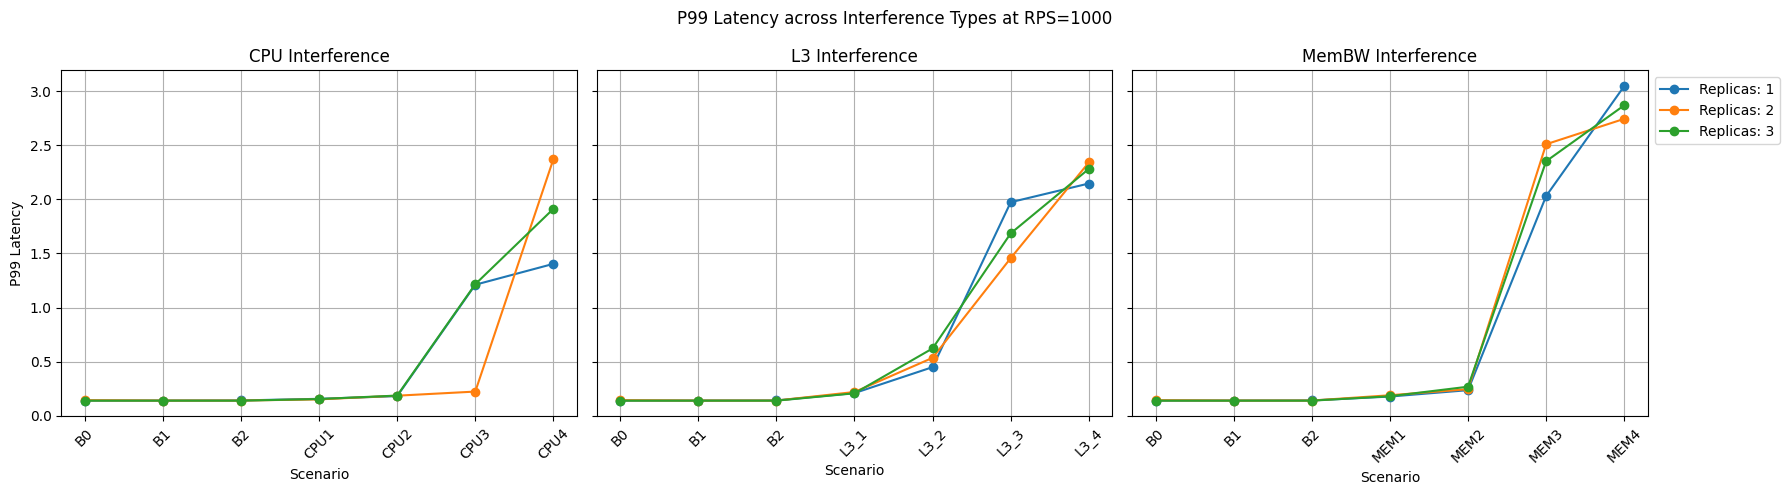

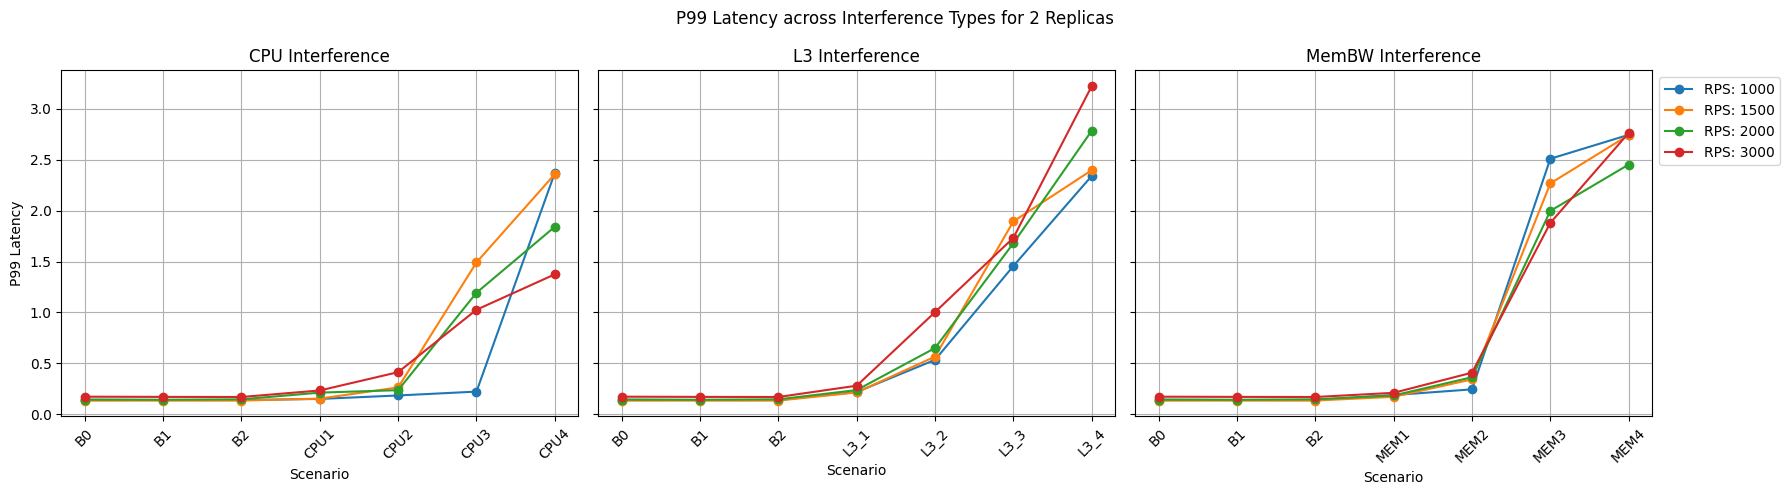

In [68]:
plot_perf_by_rps(df_perf, target_rps=1000)
plot_perf_by_replica(df_perf, target_replica=2)

### 2.1 Normalized Perfomance
**Formula:**  
$$
\mathrm{NormalizedPerf} \;=\; \frac{\mathrm{Perf}_{\text{baseline}}}{\mathrm{Perf}_{\text{interference}}}
$$

*(Perf = p90 latency, so lower is better)*

**Usage**  
- Compares “what fraction of baseline performance remains” under interference.  
- Ideal for benchmarking across heterogeneous workloads or hardware.  
- Plots easily on a uniform [0–1] scale where 1.0 means no impact.

**Why We Need It**  
- Provides a **relative**, unit‐free measure of interference impact.  
- Allows apples-to-apples comparison even when absolute latencies differ.  
- Highlights which co-locations preserve most of their performance.

In [62]:
def compute_normalized_performance(df_perf, metric='P99_Latency'):
    baseline_names = ["Baseline0", "Baseline1", "Baseline2"]

    # Filter baseline entries
    df_baseline = df_perf[df_perf["Interference_Name"].isin(baseline_names)]

    # Compute baseline means for each (Replicas, RPS) pair
    df_baseline_mean = df_baseline.groupby(["Replicas", "Given_RPS"]).agg({
        "Throughput": "mean",
        "Avg_Latency": "mean",
        "P50_Latency": "mean",
        "P75_Latency": "mean",
        "P90_Latency": "mean",
        "P95_Latency": "mean",
        "P99_Latency": "mean",
        "Max_Latency": "mean"
    }).reset_index()

    # Create lookup dictionary for (Replicas, Given_RPS) -> baseline P99
    baseline_metric_lookup = df_baseline_mean.set_index(["Replicas", "Given_RPS"])[metric].to_dict()

    def compute_norm_perf(row):
        key = (row["Replicas"], row["Given_RPS"])
        baseline_metric = baseline_metric_lookup.get(key, None)

        if row["Interference_Name"] in baseline_names:
            return 1.0
        elif baseline_metric is not None and row[metric] != 0:
            return baseline_metric / row[metric]
        else:
            return float('nan')

    df_perf = df_perf.copy()
    df_perf["norm_perf"] = df_perf.apply(compute_norm_perf, axis=1)
    return df_perf

# Example usage:
df_perf = compute_normalized_performance(df_perf)


In [63]:
df_perf

,Test_ID,Replicas,Interference_Name,Interference_ID,Given_RPS,Throughput,Avg_Latency,P50_Latency,P75_Latency,P90_Latency,P95_Latency,P99_Latency,Max_Latency,Errors,Interference_Category,norm_perf
0,1replicas_scenario0_1000rps,1,Baseline0,0,1000,1000.002195,0.086,0.083,0.0,0.100,0.106,0.140,2.407,0,Baseline,1.000000
1,1replicas_scenario1_1000rps,1,Baseline1,1,1000,1000.000243,0.086,0.084,0.0,0.099,0.106,0.140,2.314,0,Baseline,1.000000
2,1replicas_scenario2_1000rps,1,Baseline2,2,1000,1000.001156,0.088,0.085,0.0,0.101,0.110,0.141,2.427,0,Baseline,1.000000
3,1replicas_scenario11_1000rps,1,1_iBench_CPU_pod,11,1000,1000.005185,0.090,0.085,0.0,0.101,0.109,0.156,3.988,0,CPU,0.899573
4,1replicas_scenario12_1000rps,1,2_iBench_CPU_pods,12,1000,1000.002092,0.095,0.085,0.0,0.103,0.114,0.181,3.963,0,CPU,0.775322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,3replicas_scenario24_3000rps,3,4_stress-ng_l3_pods,24,3000,2999.995602,0.577,0.415,0.0,1.247,1.725,2.701,11.638,0,L3,0.062569
176,3replicas_scenario31_3000rps,3,1_iBench_memBW_pod,31,3000,3000.002268,0.102,0.094,0.0,0.135,0.153,0.218,3.808,0,Membw,0.775229
177,3replicas_scenario32_3000rps,3,2_iBench_memBW_pods,32,3000,3000.004639,0.138,0.109,0.0,0.228,0.280,0.434,6.000,0,Membw,0.389401
178,3replicas_scenario33_3000rps,3,3_iBench_memBW_pods,33,3000,3000.003176,0.225,0.145,0.0,0.338,0.509,1.990,7.522,0,Membw,0.084925


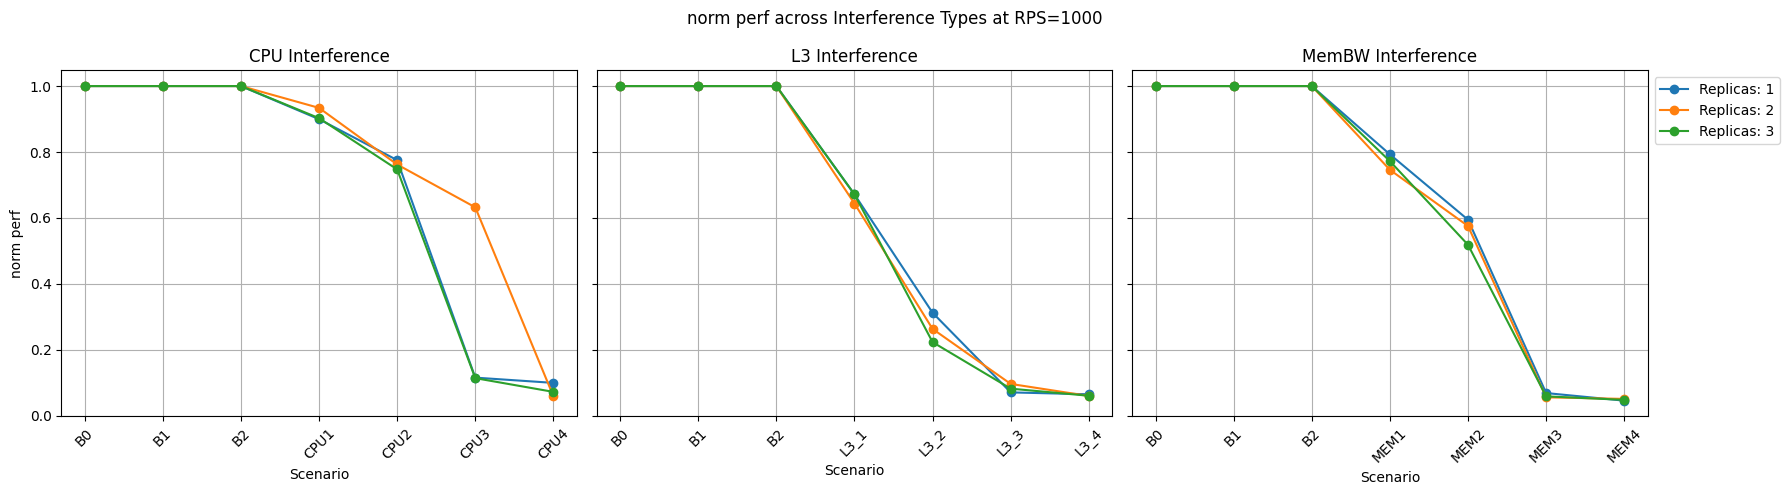

In [77]:
plot_perf_by_rps(df_perf, target_rps=1000, metric='norm_perf')

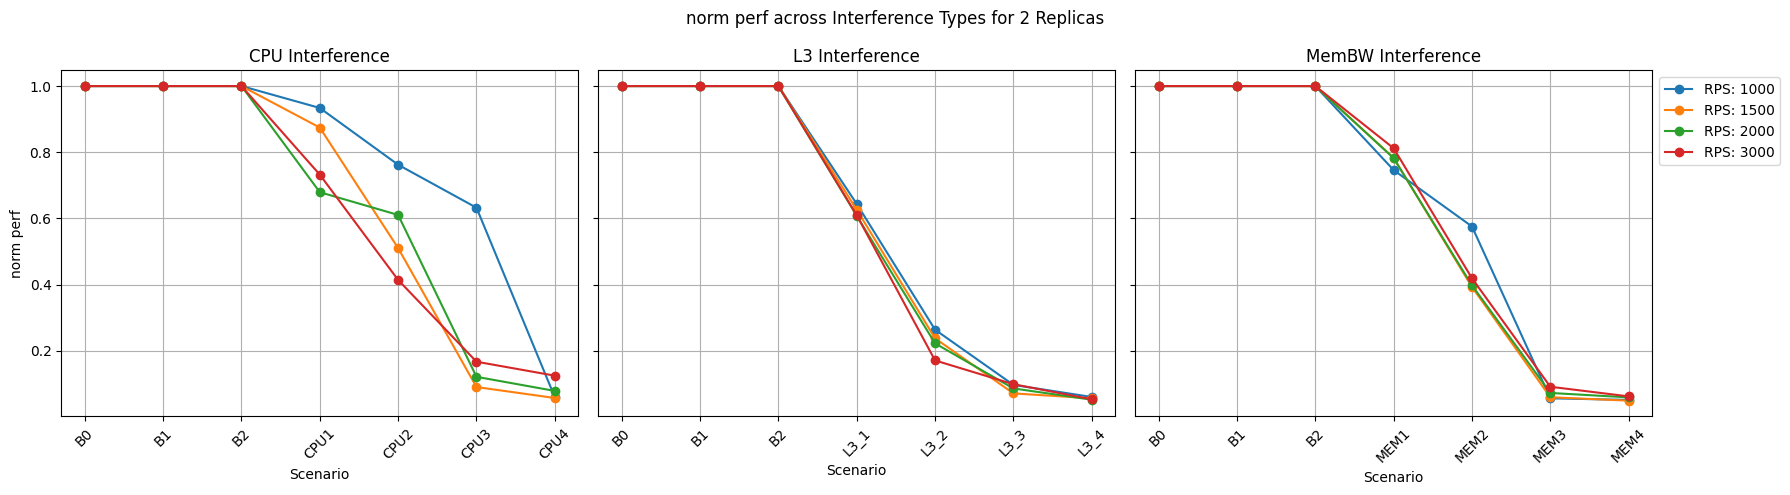

In [72]:
plot_perf_by_replica(df_perf, target_replica=2, metric='norm_perf')

### 2.2 QoS Degradation
**Formula:**  
$$
\mathrm{QoS\_Degrad\%} \;=\; \frac{\mathrm{Perf}_{\text{with-intf}} \;-\; \mathrm{Perf}_{\text{alone}}}{\mathrm{Perf}_{\text{alone}}} \times 100\%
$$
**Usage**  
- Reports the **absolute** (or percentage) change in your QoS metric (e.g. +20 ms p90).  
- Ideal for capacity-planning (“each co-tenant adds this many milliseconds of tail latency”).

**Why We Need It**  
- Conveys the **magnitude** of slowdown in concrete units.  
- Helps operators budget additional latency and plan SLAs.

### 2.3 SLO Violation

**Formula:**  
$$
\mathrm{SLO\_ViolRate} \;=\; \frac{\bigl|\{\text{requests with latency} > \text{SLO\_threshold}\}\bigr|}{\text{total requests}}
$$

**Usage**  
- Measures the **fraction** (or count) of requests that breach your latency SLO.  
- Reported as a % or per-million rate, often over time or per scenario.

**Why We Need It**  
- Directly ties interference to user-visible failures or timeouts.  
- Captures threshold effects where small latency shifts cause large violation spikes.

### 2.4 Interference Sensitivity

**Formula**  
$$
\mathrm{Sensitivity} \;=\; \frac{\mathrm{Perf}_{\text{alone}} - \mathrm{Perf}_{\text{with-intf}}}{\mathrm{Perf}_{\text{alone}}}
\;=\; 1 \;-\; \mathrm{NormalizedPerf}
$$

**Usage**  
- Ranks workloads by **percent degradation** under interference.  
- Drives scheduler heuristics: e.g. “never co-locate two pods with > 30 % sensitivity.”  
- Plots as a single “pain score” per interference scenario.

**Why We Need It**  
- A concise score of how badly each service suffers.  
- Simplifies placement decisions by collapsing multiple metrics into one.  
- Highlights which pods need strongest isolation or resource guarantees.

##  3 Profiling: 

### **Given the state of the Server, what will the effect on the Application's Perfomance be?**

### 3.1. Application Profiling (Feature Extraction)

**Objective:** For each interference scenario, aggregate high-resolution PCM counters into a fixed set of summary features.  
- Compute the **mean** and **95th percentile** for each numeric counter (IPC, cache misses, memory bandwidth, C-state residencies, etc.).  
- Label each feature vector with its `Interference` scenario name so we can join later.

**Why calculate p95?**

When summarizing high-resolution counter streams into fixed features, the **mean** captures average behavior but can miss intermittent yet impactful bursts. Computing the **95th percentile** for each metric (e.g., IPC, cache misses, memory bandwidth) lets us quantify those sustained high-interference windows without over-reacting to single outliers.  
- **Captures “Spikiness”**: If a resource experiences occasional but prolonged contention, the 95th percentile rises, signaling potential tail-latency issues.  
- **Predicts Tail Latency**: Rare but sustained high counter values often drive P99 latency spikes. Including a high-percentile feature gives our model the ability to link resource “bursts” to service-level objective (SLO) violations.  
- **Robustness**: Unlike the maximum, the 95th percentile is less sensitive to one-off anomalies, yet still focuses on the worst 5% of the sampling windows—precisely the behavior most correlated with tail performance degradation.



In [38]:
def extract_pcm_features(data_dir, target_cores=[3,4,5], include_system=False, 
                        window_size=2, stats=('mean','p95','std')):
    """
    Extract PCM features from core and optionally system CSV logs.
    
    Parameters:
    - data_dir (str): Directory containing PCM CSV files
    - target_cores (list): Core numbers to analyze (default: [3,4,5])
    - include_system (bool): Whether to include system-wide metrics
    - window_size (int): Samples for rolling window
    - stats (tuple): Statistics to compute ('mean','p95','std','max','min')
    
    Returns:
    - pd.DataFrame: One row per scenario, features + pcm_id
    """
    # Pattern to match both core and system files
    core_pattern = os.path.join(data_dir, 'pcm_core_*.csv')
    system_pattern = os.path.join(data_dir, 'pcm_system_*.csv')
    
    # Get all available files
    core_files = glob.glob(core_pattern)
    system_files = glob.glob(system_pattern) if include_system else []
    
    if not core_files and not system_files:
        print(f"⚠️ No PCM files found in {data_dir}")
        return pd.DataFrame()

    # Create mapping of scenario IDs to their features
    features_dict = {}

    # Process core files
    for filepath in core_files:
        # Extract pcm_id (e.g., "2replicas_scenario9_900rps" from "pcm_core_2replicas_scenario9_900rps.csv")
        pcm_id = os.path.basename(filepath).replace('pcm_core_', '').replace('.csv', '')
        
        if pcm_id not in features_dict:
            features_dict[pcm_id] = {'Test_ID': pcm_id}
            
        df_pcm = pd.read_csv(filepath)
        
        # Process target cores
        for core in target_cores:
            core_prefix = f'Core{core} (Socket 0) - '
            core_cols = [col for col in df_pcm.columns if col.startswith(core_prefix)]
            
            # Filter to metrics we care about
            keep_metrics = ['IPC', 'L3MISS', 'L2MISS', 'C0res%', 'C1res%', 'C6res%']
            core_cols = [col for col in core_cols if any(m in col for m in keep_metrics)]
            
            for col in core_cols:
                metric = col.replace(core_prefix, '').replace('%', '')
                clean_name = f'Core{core}_{metric}'
                s = df_pcm[col]
                
                # Compute statistics
                stats_results = compute_windowed_stats(s, window_size, stats)
                for stat, value in stats_results.items():
                    features_dict[pcm_id][f'{stat}_{clean_name}'] = value

    # Process system files if requested
    if include_system:
        for filepath in system_files:
            pcm_id = os.path.basename(filepath).replace('pcm_system_', '').replace('.csv', '')
            
            if pcm_id not in features_dict:
                features_dict[pcm_id] = {'pcm_id': pcm_id}
                
            df_sys = pd.read_csv(filepath)
            
            # Filter system metrics (excluding core-specific and unwanted metrics)
            sys_cols = [col for col in df_sys.columns 
                       if 'Core' not in col and 
                       not any(x in col for x in ["System Pack C-States", "PhysIPC%"])]
            
            for col in sys_cols:
                if ' - ' in col:
                    metric = col.split(' - ')[1].replace('%', '')
                    clean_name = f'Sys_{metric}'
                else:
                    clean_name = f'Sys_{col}'
                    
                s = df_sys[col]
                stats_results = compute_windowed_stats(s, window_size, stats)
                for stat, value in stats_results.items():
                    features_dict[pcm_id][f'{stat}_{clean_name}'] = value

    # Convert to DataFrame
    df_features = pd.DataFrame(features_dict.values())
    
    print(f"Extracted {len(df_features.columns)-1} features from {len(features_dict)} scenarios")
    return df_features

def compute_windowed_stats(series, window_size, stats):
    """Helper function to compute windowed statistics"""
    results = {}
    
    if window_size:
        win = series.rolling(window=window_size, center=True, min_periods=1)
        if 'mean' in stats: results['mean'] = win.mean().mean()
        if 'std' in stats: results['std'] = win.std().mean()
        if 'max' in stats: results['max'] = win.max().mean()
        if 'min' in stats: results['min'] = win.min().mean()
        if 'p95' in stats: results['p95'] = win.quantile(0.95).mean()
    else:
        if 'mean' in stats: results['mean'] = series.mean()
        if 'std' in stats: results['std'] = series.std()
        if 'max' in stats: results['max'] = series.max()
        if 'min' in stats: results['min'] = series.min()
        if 'p95' in stats: results['p95'] = series.quantile(0.95)
    
    return results

In [39]:
df_features_HR = extract_pcm_features(Data_Dir, target_cores=[3,4,5])
display(df_features_HR)

Extracted 63 features from 490 scenarios


,Test_ID,mean_Core3_IPC,std_Core3_IPC,p95_Core3_IPC,mean_Core3_L3MISS,std_Core3_L3MISS,p95_Core3_L3MISS,mean_Core3_L2MISS,std_Core3_L2MISS,p95_Core3_L2MISS,...,p95_Core5_C0res,mean_Core5_C1res,std_Core5_C1res,p95_Core5_C1res,mean_Core5_C6res,std_Core5_C6res,p95_Core5_C6res,mean_Core5_PhysIPC,std_Core5_PhysIPC,p95_Core5_PhysIPC
0,1replicas_scenario3_2500rps,1.146667,0.160867,1.237667,0.013333,0.001768,0.014333,0.193333,0.022981,0.206333,...,7.318111,91.370556,2.238877,92.637056,0.0,0.0,0.0,61.217778,0.602809,61.558778
1,4replicas_scenario0_100rps,0.736111,0.138770,0.814611,0.052222,0.012374,0.059222,0.144444,0.024749,0.158444,...,1.921944,77.049444,2.855828,78.664944,0.0,0.0,0.0,27.432222,3.413558,29.363222
2,4replicas_scenario5_900rps,1.555000,0.011571,1.561750,0.024583,0.008357,0.029458,0.242500,0.077139,0.287500,...,7.094708,92.907917,0.004500,92.910542,0.0,0.0,0.0,62.923750,0.264201,63.077875
3,3replicas_scenario6_2500rps,0.819167,0.079710,0.865667,0.054167,0.009000,0.059417,0.499167,0.088710,0.550917,...,0.766625,95.321250,5.298801,98.412375,0.0,0.0,0.0,31.529167,1.315219,32.296417
4,2replicas_scenario1_900rps,0.786667,0.123422,0.858667,0.020000,0.000000,0.020000,0.130833,0.017999,0.141333,...,0.386125,71.527917,1.305576,72.289542,0.0,0.0,0.0,40.675417,2.317382,42.027292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,4replicas_scenario9_2100rps,0.358333,0.025633,0.372833,2.123889,0.552427,2.436389,7.880000,0.889187,8.383000,...,13.923000,86.172222,0.171473,86.269222,0.0,0.0,0.0,10.436111,0.566569,10.756611
486,3replicas_scenario12_1300rps,1.195833,0.060425,1.231083,0.038750,0.005785,0.042125,0.135417,0.040498,0.159042,...,6.477792,82.540000,4.141074,84.955750,0.0,0.0,0.0,42.005000,2.705005,43.583000
487,3replicas_scenario3_100rps,1.290000,0.091924,1.342000,0.006111,0.004419,0.008611,0.052222,0.008839,0.057222,...,3.230667,78.874444,1.506137,79.726444,0.0,0.0,0.0,62.772778,0.338527,62.964278
488,3replicas_scenario9_1300rps,0.413889,0.053917,0.444389,0.902778,0.168822,0.998278,4.342778,0.296101,4.510278,...,13.926833,86.062222,0.028284,86.078222,0.0,0.0,0.0,10.411667,0.451664,10.667167


### 3.2. Label Joining & Normalized Performance

**Objective:**  
Merge each hardware‐counter feature vector (`df_features`) with its corresponding observed tail‐latency, then convert raw latencies into a _normalized slowdown ratio_ that becomes our RiskScore target (`norm_perf`).

**Steps:**

1. **Extract per-traffic baseline latency and Compute slowdown ratio**  
    - For each `Interference` scenario, extract the baseline latency (e.g. P99) from the row where `Interference = "baseline"`.  
    - Compute the slowdown ratio:  
      ```python
      df_perf['Normalized_Performance'] = df_perf['P99_Latency'] / df_perf['Baseline_P99_Latency']
      ```
    - This gives us a measure of how much worse the latency is under interference compared to the baseline.

3. **Merge with features and set RiskScore**  
   - Inner‐join your feature table on the `Interference` column
   - The resulting `df_ml` contains one row per experiment, with:
     - all hardware‐counter summaries
     - the normalized target `norm_perf` (Risk < 1 ⇒ likely SLO violation)

**Why use norm_perf column?**  
- **Workload-agnostic target:** by normalizing against each test’s own baseline, the model doesn’t need to learn absolute latencies for every traffic pattern—only how much interference slows it down.  
- **Aligned with SLOs:** `norm_perf` becomes a direct proxy for “fraction of SLO consumed” (e.g. predicted P99 / SLO_ms), so a learned model can output a true RiskScore that the scheduler uses to decide placement or mitigation.


In [41]:
def calculate_norm_perf(df_perf, latency_col='P99_Latency'):
    """
    Calculate normalized performance using mean baseline values for each replica+RPS combination.
    Preserves original DataFrame structure while computing correct normalized values.
    
    Args:
        df_perf: DataFrame containing performance data
        latency_col: The latency column to use for normalization (default: 'P99_Latency')
    
    Returns:
        DataFrame with added 'norm_perf' column
    """
    # Create a copy to avoid modifying original
    df = df_perf.copy()
    
    # Calculate mean baseline for each replica+RPS combination
    baseline_means = (df[df['Interference'].str.startswith('Baseline')]
                     .groupby(['Replicas', 'Given_RPS'])[latency_col]
                     .mean()
                     .reset_index()
                     .rename(columns={latency_col: 'baseline_mean'}))
    
    # Merge with original data
    df = df.merge(baseline_means, on=['Replicas', 'Given_RPS'], how='left')
    
    # Calculate normalized performance
    df['norm_perf'] = df['baseline_mean'] / df[latency_col]
    
    # Drop temporary column
    #df.drop(columns=['baseline_mean'], inplace=True)
    
    return df

# Usage:
df_perf = calculate_norm_perf(df_perf, 'P99_Latency')
display(df_perf)

,Test_ID,Replicas,Interference,Given_RPS,Throughput,Avg_Latency,P50_Latency,P75_Latency,P90_Latency,P99_Latency,Max_Latency,baseline_mean,norm_perf
0,1replicas_scenario0_100rps,1,Baseline0,100,95.02,87.05,65.0,95.0,128.0,327.0,1240.0,958.5,2.931193
1,1replicas_scenario0_500rps,1,Baseline0,500,495.00,92.98,67.0,102.0,158.0,345.0,2610.0,1402.5,4.065217
2,1replicas_scenario0_900rps,1,Baseline0,900,894.99,115.47,57.0,93.0,127.0,1830.0,4830.0,1920.0,1.049180
3,1replicas_scenario0_1300rps,1,Baseline0,1300,1262.59,565.81,393.0,746.0,1210.0,2310.0,4240.0,1255.5,0.543506
4,1replicas_scenario0_1700rps,1,Baseline0,1700,1692.89,78.96,65.0,83.0,117.0,272.0,2330.0,1056.0,3.882353
...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,5replicas_scenario13_900rps,5,8_iBench_memBW_pods,900,872.55,1100.00,596.0,1430.0,2730.0,5770.0,11120.0,1795.0,0.311092
486,5replicas_scenario13_1300rps,5,8_iBench_memBW_pods,1300,1262.49,680.91,449.0,758.0,1430.0,3470.0,11720.0,1075.0,0.309798
487,5replicas_scenario13_1700rps,5,8_iBench_memBW_pods,1700,1654.92,1080.00,569.0,1350.0,2730.0,5750.0,11390.0,193.0,0.033565
488,5replicas_scenario13_2100rps,5,8_iBench_memBW_pods,2100,2042.44,654.68,470.0,771.0,1280.0,3160.0,9870.0,1825.0,0.577532


In [42]:
if not df_perf.empty and not df_features_HR.empty:
    df_ml = df_features_HR.merge(df_perf, on='Test_ID', how='inner')
    print("Combined ML-ready dataset:")
    display(df_ml)
else:
    df_ml = pd.DataFrame()
    print("⚠️ Cannot create ML dataset: missing performance or feature data.")

# Show columns of the final dataset
print("Final dataset columns:")
print(df_ml.columns.tolist())

Combined ML-ready dataset:


,Test_ID,mean_Core3_IPC,std_Core3_IPC,p95_Core3_IPC,mean_Core3_L3MISS,std_Core3_L3MISS,p95_Core3_L3MISS,mean_Core3_L2MISS,std_Core3_L2MISS,p95_Core3_L2MISS,...,Given_RPS,Throughput,Avg_Latency,P50_Latency,P75_Latency,P90_Latency,P99_Latency,Max_Latency,baseline_mean,norm_perf
0,1replicas_scenario3_2500rps,1.146667,0.160867,1.237667,0.013333,0.001768,0.014333,0.193333,0.022981,0.206333,...,2500,2490.92,171.12,84.0,155.0,257.0,2170.0,5070.0,979.0,0.451152
1,4replicas_scenario0_100rps,0.736111,0.138770,0.814611,0.052222,0.012374,0.059222,0.144444,0.024749,0.158444,...,100,95.02,101.55,77.0,119.0,159.0,340.0,1420.0,895.0,2.632353
2,4replicas_scenario5_900rps,1.555000,0.011571,1.561750,0.024583,0.008357,0.029458,0.242500,0.077139,0.287500,...,900,894.99,286.70,61.0,97.0,940.0,3440.0,7530.0,2035.0,0.591570
3,3replicas_scenario6_2500rps,0.819167,0.079710,0.865667,0.054167,0.009000,0.059417,0.499167,0.088710,0.550917,...,2500,2490.98,84.40,77.0,95.0,119.0,199.0,1690.0,1975.0,9.924623
4,2replicas_scenario1_900rps,0.786667,0.123422,0.858667,0.020000,0.000000,0.020000,0.130833,0.017999,0.141333,...,900,872.55,382.26,278.0,475.0,834.0,1430.0,3320.0,889.5,0.622028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,4replicas_scenario9_2100rps,0.358333,0.025633,0.372833,2.123889,0.552427,2.436389,7.880000,0.889187,8.383000,...,2100,2092.03,399.69,264.0,422.0,742.0,2410.0,10040.0,931.5,0.386515
486,3replicas_scenario12_1300rps,1.195833,0.060425,1.231083,0.038750,0.005785,0.042125,0.135417,0.040498,0.159042,...,1300,1262.54,555.96,342.0,639.0,1260.0,3190.0,6150.0,1380.0,0.432602
487,3replicas_scenario3_100rps,1.290000,0.091924,1.342000,0.006111,0.004419,0.008611,0.052222,0.008839,0.057222,...,100,95.02,151.48,78.0,119.0,173.0,2140.0,4160.0,865.5,0.404439
488,3replicas_scenario9_1300rps,0.413889,0.053917,0.444389,0.902778,0.168822,0.998278,4.342778,0.296101,4.510278,...,1300,1262.54,1180.00,825.0,1370.0,2330.0,5980.0,16880.0,1380.0,0.230769


Final dataset columns:
['Test_ID', 'mean_Core3_IPC', 'std_Core3_IPC', 'p95_Core3_IPC', 'mean_Core3_L3MISS', 'std_Core3_L3MISS', 'p95_Core3_L3MISS', 'mean_Core3_L2MISS', 'std_Core3_L2MISS', 'p95_Core3_L2MISS', 'mean_Core3_C0res', 'std_Core3_C0res', 'p95_Core3_C0res', 'mean_Core3_C1res', 'std_Core3_C1res', 'p95_Core3_C1res', 'mean_Core3_C6res', 'std_Core3_C6res', 'p95_Core3_C6res', 'mean_Core3_PhysIPC', 'std_Core3_PhysIPC', 'p95_Core3_PhysIPC', 'mean_Core4_IPC', 'std_Core4_IPC', 'p95_Core4_IPC', 'mean_Core4_L3MISS', 'std_Core4_L3MISS', 'p95_Core4_L3MISS', 'mean_Core4_L2MISS', 'std_Core4_L2MISS', 'p95_Core4_L2MISS', 'mean_Core4_C0res', 'std_Core4_C0res', 'p95_Core4_C0res', 'mean_Core4_C1res', 'std_Core4_C1res', 'p95_Core4_C1res', 'mean_Core4_C6res', 'std_Core4_C6res', 'p95_Core4_C6res', 'mean_Core4_PhysIPC', 'std_Core4_PhysIPC', 'p95_Core4_PhysIPC', 'mean_Core5_IPC', 'std_Core5_IPC', 'p95_Core5_IPC', 'mean_Core5_L3MISS', 'std_Core5_L3MISS', 'p95_Core5_L3MISS', 'mean_Core5_L2MISS', 'std_Co

### 3.3. Preprocessing & Pipeline Construction

**Objective:**  
Turn our raw hardware‐counter summaries into a compact, consistent input for a regressor that predicts the slowdown ratio (`Risk_obs`), while avoiding overfitting on just 24 experiments.

---

#### 1. Feature Selection  
- **Include all sliding-window stats:**  
  - `mean_`, `std_`, `p95_`  
- **Why?** These five measures per counter capture central tendency, variability, peaks, troughs, and tail‐behavior bursts—key signals for tail-latency.

#### 2. The Pipeline & Its Steps  
- **StandardScaler**: Normalize each feature to zero mean and unit variance.
- **PolynomialFeatures**: Expand the feature set with polynomial combinations of the original features.
- **PCA**: Reduce dimensionality while preserving variance.
- **RandomForestRegressor**: Train a regression model to predict the slowdown ratio.


In [43]:
from sklearn.decomposition import PCA

# 1. Identify feature columns and target
stat_prefixes = ('mean_', 'std_', 'p95_')
feature_cols = [c for c in df_ml.columns if c.startswith(stat_prefixes)]
# Group by replica count and train separate models
models = {}
for replicas, group in df_ml.groupby('Replicas'):
    X = group[feature_cols]
    y = group['norm_perf']
    
    model_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('pca', PCA(n_components=20, random_state=42)),
        ('reg', RandomForestRegressor(n_estimators=100, random_state=42))
    ])
    
    model_pipeline.fit(X, y)
    models[replicas] = model_pipeline

# 4. (Optional) Inspect explained variance of the components
explained = model_pipeline.named_steps['pca'].explained_variance_ratio_.sum()
print(f"Retained {explained:.1%} of variance in 20 components")

Retained 92.0% of variance in 20 components


### 3.4 Model Training & Evaluation

**Objective:**  
Assess how well our pipeline predicts the normalized slowdown (`norm_perf`) on interference scenarios it hasn’t seen, and quantify the expected error.

1. **Cross-Validation Strategy**  
   - We use **Leave-One-Interference-Level-Out** (LeaveOneGroupOut) CV, grouping by the `Interference` label.  
   - Each fold trains on all but one interference intensity (e.g. CPU×2, MemBW×4, etc.) and tests on the held-out level—mimicking how we need to generalize to new contention patterns.

2. **Scoring Metrics**  
   - **Mean Squared Error (MSE):** penalizes large deviations heavily; tells us how far off our predicted slowdown is, on average, in squared units.  
   - **Mean Absolute Error (MAE):** more interpretable “on average we’re ±X% off” in the slowdown ratio.

3. **Interpreting Results**  
   - A low MAE (e.g. 0.05) means we predict that a node’s tail latency will be within 5% of its true slowdown.  
   - These errors guide confidence in scheduling decisions: if the predicted slowdown differences between two nodes exceed our MAE, we can reliably pick the best node.

4. **Scheduler Integration**  
   - At runtime, the scheduler will load this **trained pipeline**, sample live hardware counters on each node, and compute `predicted_norm_perf`.  
   - It then assigns new pods to the node with the lowest predicted slowdown, or triggers mitigation if all nodes exceed an acceptable threshold.

By successfully completing this subsection, we’ll have a validated, quantifiable predictor of interference-induced slowdowns—our RiskScore—that the scheduler can trust for placement decisions.  


In [44]:
from sklearn.model_selection import cross_validate, LeaveOneGroupOut
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
import pandas as pd

# Initialize storage for results
all_results = []

# Define scorers
scoring = {
    'MSE': make_scorer(mean_squared_error),
    'MAE': make_scorer(mean_absolute_error)
}

# Process each replica count separately
for replicas, group in df_ml.groupby('Replicas'):
    print(f"\n=== Processing Replica Count: {replicas} ===")
    
    # Features & target for this replica count
    X = group[[c for c in group.columns if c.startswith(stat_prefixes)]]
    y = group['norm_perf']
    groups = group['Interference']
    
    # Define CV splitter - leaving one interference type out each time
    logo = LeaveOneGroupOut()
    
    # Perform cross-validation
    cv_results = cross_validate(
        model_pipeline, X, y,
        cv=logo.split(X, y, groups=groups),
        scoring=scoring,
        return_train_score=False
    )
    
    # Store results with replica count information
    results_df = pd.DataFrame({
        'Replicas': replicas,
        'Fold': range(len(cv_results['test_MSE'])),
        'MSE': cv_results['test_MSE'],
        'MAE': cv_results['test_MAE']
    })
    all_results.append(results_df)
    
    # Print summary for this replica count
    print(f"Results for Replicas={replicas}:")
    print(f"  Average MSE: {cv_results['test_MSE'].mean():.4f}")
    print(f"  Average MAE: {cv_results['test_MAE'].mean():.4f}")
    print(f"  Number of samples: {len(group)}")

# Combine all results
final_results = pd.concat(all_results)

# Optional: Print overall statistics
print("\n=== Overall Summary ===")
print(final_results.groupby('Replicas')[['MSE', 'MAE']].mean())


=== Processing Replica Count: 1 ===
Results for Replicas=1:
  Average MSE: 1.2987
  Average MAE: 0.9221
  Number of samples: 98

=== Processing Replica Count: 2 ===
Results for Replicas=2:
  Average MSE: 0.9567
  Average MAE: 0.7359
  Number of samples: 98

=== Processing Replica Count: 3 ===
Results for Replicas=3:
  Average MSE: 4.4848
  Average MAE: 1.4056
  Number of samples: 98

=== Processing Replica Count: 4 ===
Results for Replicas=4:
  Average MSE: 3.3650
  Average MAE: 1.3033
  Number of samples: 98

=== Processing Replica Count: 5 ===
Results for Replicas=5:
  Average MSE: 2.0553
  Average MAE: 0.9083
  Number of samples: 98

=== Overall Summary ===
               MSE       MAE
Replicas                    
1         1.298672  0.922128
2         0.956670  0.735861
3         4.484821  1.405643
4         3.365001  1.303333
5         2.055276  0.908344


### 3.5 Testing the Predictor on Real Data

**Goal:** Given a fresh PCM trace, forecast its slowdown and compare it against the single observed P90 latency.

1. **Feature Extraction**  
   - We call `extract_pcm_features(...)` on the `HR_Test` folder to compute the same sliding-window stats used during training.

2. **Prediction**  
   - We pass those stats into `model_pipeline.predict(...)` and capture `predicted_Risk`, our model’s estimate of slowdown (e.g., 5× slower than baseline).

3. **Observe True P90**  
   - We read the lone `P90_Latency` value from `workload_metrics.csv` (e.g., 46970 ms).

4. **Baseline Reference**  
   - We fetch the original baseline P90 (9430 ms) from our training DataFrame (`df_perf`), without relying on labels in the test CSV.

5. **Compute Actual Slowdown**  
   - `actual_Risk = observed_p90 / baseline_p90` (e.g., 46970 / 9430 ≈ 4.98).

6. **Comparison**  
   - Present a simple table showing `predicted_Risk` vs. `actual_Risk`.  
   - Close agreement validates that our offline-trained pipeline delivers reliable slowdown estimates for scheduler decision-making.


In [ ]:
import os
import pandas as pd

# --- 1. Extract PCM features for the test run ---
test_dir   = "Nginx_Test"
traffic_id = "light-test_cpu_1_l3_1"      # matches the suffix in pcm_system_metrics_TC-VM-01_test.csv
window_size = 5              # same window size used during training
stats       = ('mean','std','p95')

df_test_feat = extract_pcm_features(
    data_dir=test_dir
)

# --- 2. Predict slowdown ratio with the trained pipeline ---
feature_cols = [c for c in df_test_feat.columns if c.startswith(('mean_','std_','p95_'))]
X_test        = df_test_feat[feature_cols]
predicted_risk = model_pipeline.predict(X_test)[0]

# --- 3. Load the observed P90 latency for this test run ---
df_workload = pd.read_csv(os.path.join(test_dir, "workload_metrics.csv"))
observed_p90 = df_workload["P99_Latency"].iloc[0]    # e.g. 46970.0 ms

# --- 4. Look up the baseline P90 latency from the training data (df_perf) ---
baseline_p90 = 638.0 ## Medium Traffic - Baseline P90 Latency

# --- 5. Compute the actual slowdown ratio ---
actual_risk = baseline_p90 / observed_p90

# --- 6. Display predicted vs. actual slowdown ---
error_percent = 100 * abs(predicted_risk - actual_risk) / actual_risk

result = pd.DataFrame({
    "predicted_Risk": [predicted_risk],
    "actual_Risk":    [actual_risk],
    "error_percent":  [error_percent]
})
print("Predicted vs. Actual Slowdown Ratios:")
display(result)


Extracted 63 features from 1 scenarios
Predicted vs. Actual Slowdown Ratios:


,predicted_Risk,actual_Risk,error_percent
0,1.868313,0.425333,339.258653


## 4. Exporting the Predictor

In [22]:
import joblib
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Export each model to a separate .pkl file
for replicas, model in models.items():
    filename = f"model_replicas_{replicas}.pkl"
    joblib.dump(model, filename)
    print(f"Saved model for {replicas} replicas to {filename}")

# Verify file sizes (optional)
import os
for replicas in models.keys():
    filename = f"model_replicas_{replicas}.pkl"
    print(f"{filename}: {os.path.getsize(filename) / 1024:.1f} KB")

Exported predictor to slowdown_predictor_full.pkl and slowdown_predictor_lite.pkl
PCA retains 99.9% of variance


In [ ]:
import joblib
import numpy as np

# Load one model to test
test_model = joblib.load("model_replicas_1.pkl")

# Create dummy input data with the same shape as your training data
# Replace with actual feature dimensions from your dataset
dummy_input = np.random.rand(1, len(feature_cols))  

# Test prediction
try:
    prediction = test_model.predict(dummy_input)
    print(f"Test prediction: {prediction[0]:.3f}")
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error in model loading/prediction: {str(e)}")

Loaded predictor with:
- 24 feature columns
- Model type: Pipeline
